# Hazard: WildFire

This class is used to model the wildfire hazard using the historical data available and creating synthetic fires which are summarized into event years to establish a comprehensiv probabilistic risk assessment. 

The historical data used comes from the [Fire Information for Resource Management System (FIRMS)](https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/about-firms). They collect temperatures from the following satellite instruments:

    - Moderate Resolution Imaging Spectroradiometer  (MODIS): Near real time or standard quality data with 1 km resolution. Data available from November 2000 to present.

    - Visible Infrared Imaging Radiometer Suite (VIIRS): Near real time data with 0.375 km resolution. Data available from 20 January 2012 to present.

The data should be obtained at https://firms.modaps.eosdis.nasa.gov/download/ and saved as .csv file. Approximatly 15 min after submitting the request, the data can be downloaded by checking the request status. 

The `WildFire` class inherits from the `Hazard` class and has an associated hazard type `WF`. It provides a `set_hist_fire_FIRMS()` method which enables to fill the hazard with historical events, a `set_hist_fire_seasons_FIRMS()` method which aggregates historic events to event years, and a `set_proba_fire_seasons()` method which generates random event years. `hull_burned_area()` can be used to approximate the burned area of an event. It approximates a concave hull containing all the burned centroids and computes its area in hectares.

Some additional notes:
- as compared to other hazards (i.e. TC) there's no clear definition on what an event is for Bush Fires. While some countries (i.e. US, Australia) provide very detailed reports, other's (i.e. Chile, Indonesia) rather provide information on the whole fire season. Thus, we produce probabilistic fire seasons rather than single events to ensure global consistency. However, for case studies or calibration studies, identification of single fire events is still of importance. Thus, we differentiate in the hazard tag: 'WFsingle' for individual fires as recognized by the algorithm, 'WFseason' for whole fire seasons.

- Wildfires are hazards with a huge societal component - in many cases humans are not only responisble for starting one, but also for ending it (fire fighting). This means, that worst case scenarios (i.e. a wild fire spreading to down town Los Angeles) are less likely, as compared to TC risk, where it is highly likely that a stong TC strikes Manila and people have no chance to prevent that from happening.

- In our default version for creating probabilistic fire seasons, we rely fully on past data. Thus, in the default, this module is not suited to conduct studies on climate change risk. However, the generation of synthetic fire seasons can be manipulated.

## HISTORICAL EVENTS

In June 2017, Portugal was hit by a series of deadly wild fires which led to 66 fatalities, more than 200 mn. USD damages and 45'000 ha burned area. With `set_hist_fire_FIRMS()` we can model the fires in Portugal in 2017.

An event is defined when the temporal and spatial distance of the burning centroids is close enough. There are two attributes of the class which define the "closeness":

    - days_thres (int): temporal distance in days. Default: 2.
    - clus_thres (int): factor to multiply to the centroids resolution. Used to determine the cluster maximum distance between two centroids. Default: 15.
    
In addition to the `Hazard` attibutes, `WildFire` contains a `date_end` attribute which contains the ending date of each event.

2021-02-03 17:10:38,071 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.
2021-02-03 17:10:42,816 - climada.hazard.wildfire - INFO - Remaining fires to identify: 0.
2021-02-03 17:10:42,845 - climada.hazard.wildfire - INFO - Computing intensity of 7 fires.
2021-02-03 17:10:43,038 - climada.hazard.wildfire - INFO - Returning 7 fires that impacted the defined centroids.


/Users/sam/Documents/Python/climada_python/climada/util/plot.py:315: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


/opt/anaconda3/envs/climada_env/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))


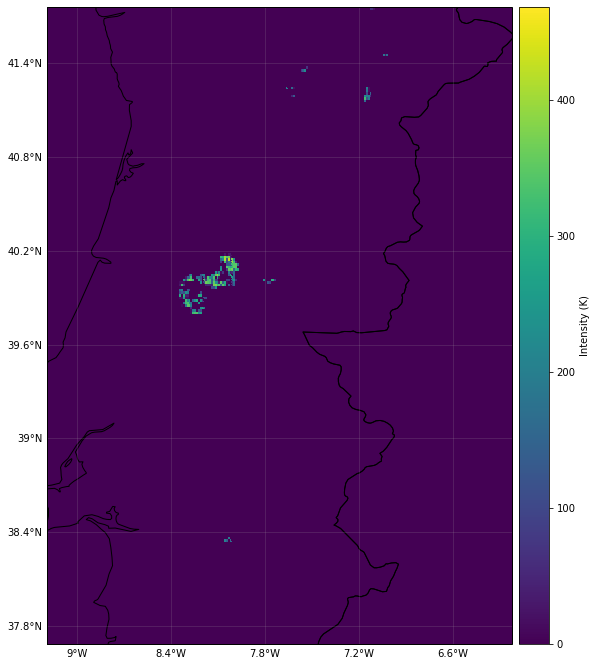

In [21]:
# Fires in Portugal 2017
%matplotlib inline
import os

from climada.util import DATA_DIR
from climada.hazard import WildFire

# Data downloaded for MODIS
d_path = os.path.join(DATA_DIR, "demo/Portugal_firms_June_2017.csv")

# set up bush fire
wf_pt = WildFire()
wf_pt.set_hist_fire_FIRMS(d_path)

# plot the maximum intensity of all the events at each centroid
wf_pt.plot_intensity(event=0)

We can focus on the region around Coimbra where the most deadly fire occured.

A given set of points or grid can be provided using the `Centroids` class. The events will be interpolated to the provided coordinates. Rather than defining the centroids upfront, the FIRMS data can also be modified, as the method accepts a path to a FIRMS.csv but also an already loaded pandas dataframe.

2021-02-03 17:10:50,026 - climada.hazard.wildfire - INFO - Remaining fires to identify: 0.
2021-02-03 17:10:50,054 - climada.hazard.wildfire - INFO - Computing intensity of 7 fires.
2021-02-03 17:10:50,085 - climada.hazard.wildfire - INFO - Returning 2 fires that impacted the defined centroids.


/Users/sam/Documents/Python/climada_python/climada/util/plot.py:315: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


/opt/anaconda3/envs/climada_env/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))


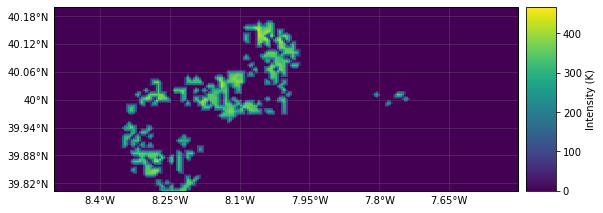

In [22]:
from climada.hazard import Centroids
from climada.util.constants import ONE_LAT_KM

# focus on Coimbra region with 1.0 km resolution (MODIS resolution)
res = 1.0/ONE_LAT_KM
centr_zoom = Centroids()
centr_zoom.set_raster_from_pnt_bounds((-8.5, 39.8, -7.5, 40.2), res)

wf_zoom = WildFire()
wf_zoom.set_hist_fire_FIRMS(d_path, centroids=centr_zoom)
wf_zoom.plot_intensity(0)

In [23]:
print('Burned area of Coimbra fires:', wf_zoom.hull_burned_area(1), ' ha.')

Burned area of Coimbra fires: 13666.834995728877  ha.


See more infos on [Wikipedia](https://en.wikipedia.org/wiki/June_2017_Portugal_wildfires) around the fire.

## HISTORIC FIRE SEASONS

`set_hist_fire_seasons_FIRMS()` generates historic fire seasons.

These fire seasons can later be compared to the probabilistic event years for a seamless risk analysis.
Note:
- all the underlying events of a year are merged into one single event which is saved.
- The original events, that result from the clustering are not kept in order to save space. However, this can be done setting the parameter `keep_all_events` to true.
- If single fires are already set, the can be aggregated to seasons using `summarize_fires_to_seasons()` 

2021-02-03 17:11:20,973 - climada.hazard.wildfire - INFO - Setting up historical fires for year set.
2021-02-03 17:11:21,019 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.
2021-02-03 17:11:26,482 - climada.hazard.wildfire - INFO - Setting up historical fire seasons 2016.
2021-02-03 17:11:27,752 - climada.hazard.wildfire - INFO - Remaining fires to identify: 3388.
2021-02-03 17:11:28,172 - climada.hazard.wildfire - INFO - Remaining fires to identify: 11.
2021-02-03 17:11:28,221 - climada.hazard.wildfire - INFO - Remaining fires to identify: 0.
2021-02-03 17:11:28,758 - climada.hazard.wildfire - INFO - Computing intensity of 113 fires.
2021-02-03 17:11:29,951 - climada.hazard.wildfire - INFO - Returning 113 fires that impacted the defined centroids.
2021-02-03 17:11:31,386 - climada.hazard.wildfire - INFO - Setting up historical fire seasons 2017.
2021-02-03 17:11:32,678 - climada.hazard.wildfire - INFO - Remaining fires to identify: 2392.
2021-

/Users/sam/Documents/Python/climada_python/climada/util/plot.py:315: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


/opt/anaconda3/envs/climada_env/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))


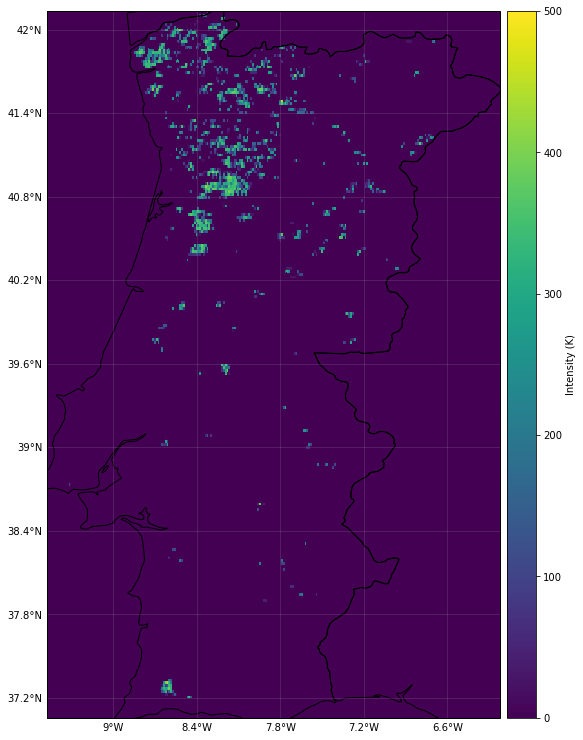

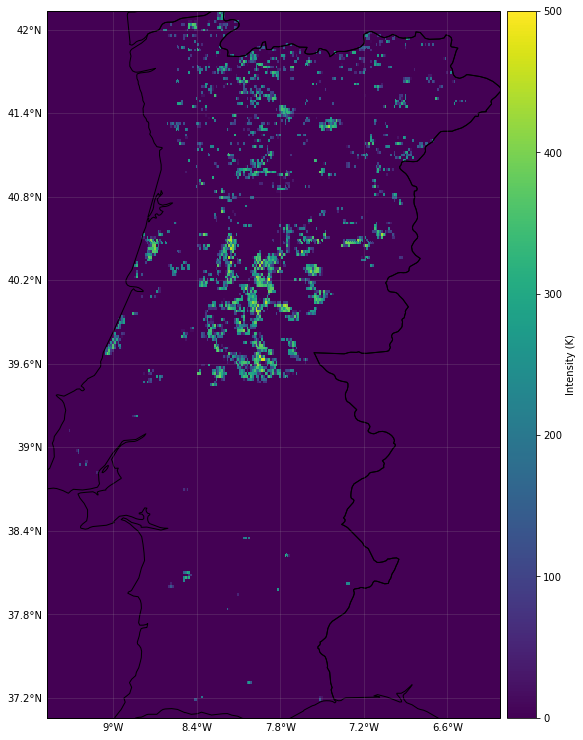

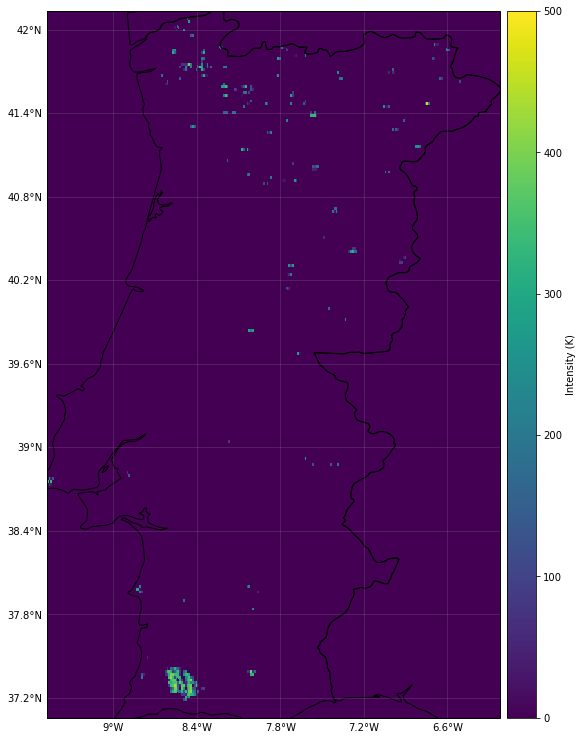

In [24]:
# load FIRMS data for 2016-2018 an select main land Portugal only
import pandas as pd

firms = pd.read_csv(os.path.join(DATA_DIR, "demo/Portugal_firms_2016_17_18_MODIS.csv"))
firms = firms[firms['latitude']>35.]
firms = firms[firms['longitude']>-12.]


wf_years = WildFire()
wf_years.set_hist_fire_seasons_FIRMS(firms, centr_res_factor=1/1.)

print('Events are now named according to their event year:', wf_years.event_name)
print('The number of underyling events is saved as well:', wf_years.n_fires)

# plot the three fire seasons (2016, 2017, 2018)
wf_years.plot_intensity(1)
wf_years.plot_intensity(2)
wf_years.plot_intensity(3)

## PROBABILISTIC FIRE SEASONS

`set_proba_fire_seasons()` generates synthetic fire seasons.

A probabilistic fire season is generate the following way:

1. A fire propagation probability matrix is defined
        - this propagation matrix defines the probabilitiy for fire propagation on each centroid
        - if not further specified, the observation of historic data is used -> the fire can only propagate on centroids that burned in the past, including a blurr around these centroids
        - this matrix can be used to include additional information (i.e. on vegetation/land-use/elevation/population density)
        - the fire propagation probability matrix is stored in `wf.centroids.fire_propa_matrix` as an np.array and thus can be adjusted easily
        
2. A random number n of fires that occured in the probabilistic year is chosen.
        - If nothing else is specified, a random number within the range of n_fires (the number of historic events is drawn)
        - The range can also be specified in the input via the parameter `n_ignition`
        
3. n synthetic fires are generated following this logic:
        - A random fire ignition point is selected (the point needs to be burnable on the fire propagation matrix)
        - The fire is then propagated from the ignition point as a cellular automat following these rules :
        1. an neighbouring centroid to the burning centroid becomes a burning centroid with a probability p. This probability is calculated as the product of a overall fire propagation probability (default=0.21) and the centroid specific factor (which is defined on the fire propagation probabilit matrix)
        2. an already burning centroid becomes an ember centroid (does not propagate fire anymore but is labled as burned)
        3. an ember centroid stays an ember centroid
        4. The propagation stops when there is no burning centroid left.
        5. The temperature provided to each centroid is randomly chosen from the corresponding historical event.
        
4. These n synthetic events are summarized into a probabilistic fire season which is appended to the historicfire seasons

Note: In the default no additional external data is included. The probabilistic event thus soley relies on past experience which likely leads to an underestimation of the current and future fire risk. The frame work allows to include climate change effects by:
   - defining the fire propagation probability matrix (using more data as described above)
   - varying the overall fire propagation probability (by i.e. linking it to a fire weather index)
   - varying the number of events per year (by i.e. linking it to a fire weather index)

2021-02-03 17:11:57,829 - climada.hazard.wildfire - INFO - Setting up probabilistic fire season with 153 fires.
2021-02-03 17:11:58,174 - climada.hazard.wildfire - INFO - Created 0 fires
2021-02-03 17:11:59,027 - climada.hazard.wildfire - INFO - Created 10 fires
2021-02-03 17:11:59,242 - climada.hazard.wildfire - INFO - Created 20 fires
2021-02-03 17:11:59,426 - climada.hazard.wildfire - INFO - Created 30 fires
2021-02-03 17:11:59,638 - climada.hazard.wildfire - INFO - Created 40 fires
2021-02-03 17:11:59,835 - climada.hazard.wildfire - INFO - Created 50 fires
2021-02-03 17:12:00,056 - climada.hazard.wildfire - INFO - Created 60 fires
2021-02-03 17:12:00,260 - climada.hazard.wildfire - INFO - Created 70 fires
2021-02-03 17:12:00,545 - climada.hazard.wildfire - INFO - Created 80 fires
2021-02-03 17:12:00,781 - climada.hazard.wildfire - INFO - Created 90 fires
2021-02-03 17:12:00,984 - climada.hazard.wildfire - INFO - Created 100 fires
2021-02-03 17:12:01,175 - climada.hazard.wildfire - 

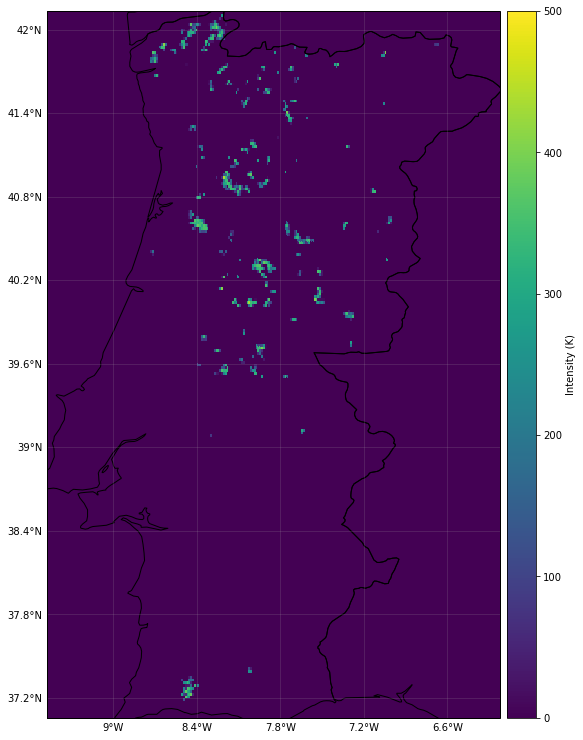

In [25]:
# generate 1 probabilistic event year for Portugal
wf_years.set_proba_fire_seasons(n_fire_seasons=1)
print('The probabilistic event year is appended to the historic:', wf_years.event_name)

# Plot the synthetic event year
wf_years.plot_intensity(event=4)

2021-02-03 17:12:07,561 - climada.hazard.wildfire - INFO - Setting up probabilistic fire season with 146 fires.
2021-02-03 17:12:07,895 - climada.hazard.wildfire - INFO - Created 0 fires
2021-02-03 17:12:08,069 - climada.hazard.wildfire - INFO - Created 10 fires
2021-02-03 17:12:08,263 - climada.hazard.wildfire - INFO - Created 20 fires
2021-02-03 17:12:08,456 - climada.hazard.wildfire - INFO - Created 30 fires
2021-02-03 17:12:08,642 - climada.hazard.wildfire - INFO - Created 40 fires
2021-02-03 17:12:08,819 - climada.hazard.wildfire - INFO - Created 50 fires
2021-02-03 17:12:09,002 - climada.hazard.wildfire - INFO - Created 60 fires
2021-02-03 17:12:09,150 - climada.hazard.wildfire - INFO - Created 70 fires
2021-02-03 17:12:09,317 - climada.hazard.wildfire - INFO - Created 80 fires
2021-02-03 17:12:09,502 - climada.hazard.wildfire - INFO - Created 90 fires
2021-02-03 17:12:09,664 - climada.hazard.wildfire - INFO - Created 100 fires
2021-02-03 17:12:09,823 - climada.hazard.wildfire - 

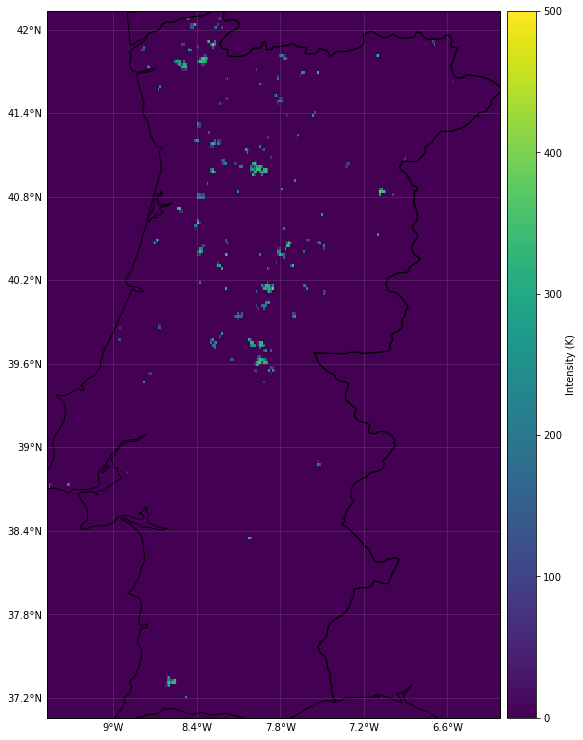

In [26]:
# The overall fire propagation probability can easily be modified (default is 0.21)
wf_years.prop_proba = 0.18
# The range of the number of events for a synthetic year can be modified when creating the event years
ign_range = [125,150]

wf_years.set_proba_fire_seasons(n_fire_seasons=2, n_ignitions=ign_range)
wf_years.plot_intensity(event=5)


## Impact calculation

Calibrated impact functions are available within `climada.entity.impact_funcs.wildfire`. The calculation was performed on a 10 km resolution (please refer to the work by Lüthi et al. 2021).

Note:
- as there is the ambiguity between single fires and fire seasons, the hazard.tag must be set accordingly in the impact function
- working on higher resolution often requires better resolved exposure data, especially on rural sites, where the LitPop approach is limited (i.e. an expensive wineyard does not glow in the night)